In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import numpy as np # Don't use this other than for matplotlib
from numpy import array
import copy

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

train_set = torchvision.datasets.FashionMNIST("./data", download=True,
                                              transform=transform)
indices = list(range(len(train_set)))
np.random.shuffle(indices)
train_after_split = SubsetRandomSampler(indices[:50000])
validation_after_split = SubsetRandomSampler(indices[50000:])

train_loader = torch.utils.data.DataLoader(train_set, sampler=train_after_split, batch_size=20)
validation_loader = torch.utils.data.DataLoader(train_set, sampler=validation_after_split, batch_size=20)


test_set = torchvision.datasets.FashionMNIST("./data", download=True, 
                                             train=False, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                         shuffle=False)

classes = ("T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot")

Our image batch shape is torch.Size([20, 1, 28, 28])


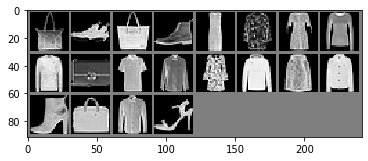

  Bag Sneaker   Bag Ankle Boot


In [3]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
print("Our image batch shape is", images.size())
imshow(torchvision.utils.make_grid(images))

print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

In [4]:
import random

# Noise is added by removing one or two quadrants of the image
# def noise_old(x):
#     #temp = x
#     for k in range(0,2):
#         #print("Iteration ", k)
#         x_offset = random.choice([0,14])
#         y_offset = random.choice([0,14])
#         #print("X: ", x_offset, " Y: ", y_offset)
#         for i in range(x_offset, x_offset+14):
#             for j in range(y_offset, y_offset+14):
#                 x[i][j] = 0
#     return x

def noise(x):
    #print(type(x))
    x = array(x)
    for k in range(0,2):
        #print("Iteration ", k)
        x_offset = random.choice([0,14])
        for i in range(x_offset, x_offset+14):
            x[x_offset:x_offset+14,x_offset:x_offset+14] = torch.zeros(x[x_offset:x_offset+14,x_offset:x_offset+14].shape)
    x = torch.from_numpy(x)
    #print(type(x))
    return x
            
# Apply noise to a set of images
def apply_noise(imgs):
    noisy_imgs = copy.deepcopy(imgs)
            
    for i in range(0, len(imgs)):
        noisy_imgs[i][0] = noise(imgs[i][0])

    #imgs = imgs.view(imgs.size(0), -1)
    #noisy_imgs = noisy_imgs.view(noisy_imgs.size(0), -1)
    
    return imgs, noisy_imgs

In [5]:
# Test noise function
# arr = [[1 for i in range(28)] for j in range(28)]
# arr2 = [[1 for i in range(28)] for j in range(28)]
# big = [arr, arr2]
# apply_noise(big)
# for x in big:
#     print(np.matrix(x))

In [6]:
z_size = 32

class Autoencoder(nn.Module):
    def __init__(self, z_size):
        super(Autoencoder, self).__init__()
        self.z_size = z_size
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)
        
    def forward(self, input_x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(input_x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = .sigmoid(self.conv_out(x))
        return x

In [7]:
autoencoder = Autoencoder(z_size)
mse_loss = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [8]:
import datetime

train_loss_list = []
val_loss_list = []

def train():
    start_training_time = datetime.datetime.now()
    epochs = 20
    
    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0
        
        for train_data in train_loader:
            train_imgs, _ = train_data
            train_imgs, train_noisy_imgs = apply_noise(train_imgs)
            
            optimizer.zero_grad()
            train_output = autoencoder(train_noisy_imgs)
            loss_func = mse_loss(train_output, train_imgs)
            loss_func.backward()
            optimizer.step()
            train_loss += loss_func.item()#*train_imgs.size(0)
            
        train_loss = train_loss/len(train_loader)
        train_loss_list.append(train_loss)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))
            
        autoencoder.eval()
        with torch.no_grad():
            for validation_data in validation_loader:
                val_imgs, _ = validation_data
                val_imgs, val_noisy_imgs = apply_noise(val_imgs)
                
                val_output = autoencoder(val_noisy_imgs)
                loss_func = mse_loss(val_output, val_imgs)
                val_loss += loss_func.item()#*train_imgs.size(0)
        
        val_loss = val_loss/len(validation_loader)
        val_loss_list.append(val_loss)
        print('Epoch: {} \tValidation Loss: {:.6f}'.format(
            epoch, 
            val_loss
            ))
        
    end_training_time = datetime.datetime.now()
    diff_training_time = end_training_time - start_training_time
    print(diff_training_time)
    
    return train_loss_list, val_loss_list

In [9]:
train_loss, val_loss = train()

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 	Training Loss: 0.690387
Epoch: 0 	Validation Loss: 0.680889
Epoch: 1 	Training Loss: 0.681765
Epoch: 1 	Validation Loss: 0.680889
Epoch: 2 	Training Loss: 0.681765
Epoch: 2 	Validation Loss: 0.680889
Epoch: 3 	Training Loss: 0.681765
Epoch: 3 	Validation Loss: 0.680889
Epoch: 4 	Training Loss: 0.681765
Epoch: 4 	Validation Loss: 0.680889
Epoch: 5 	Training Loss: 0.681765
Epoch: 5 	Validation Loss: 0.680889
Epoch: 6 	Training Loss: 0.681765
Epoch: 6 	Validation Loss: 0.680889
Epoch: 7 	Training Loss: 0.681765
Epoch: 7 	Validation Loss: 0.680889
Epoch: 8 	Training Loss: 0.681765
Epoch: 8 	Validation Loss: 0.680889
Epoch: 9 	Training Loss: 0.681765
Epoch: 9 	Validation Loss: 0.680889
Epoch: 10 	Training Loss: 0.681765
Epoch: 10 	Validation Loss: 0.680889
Epoch: 11 	Training Loss: 0.681765
Epoch: 11 	Validation Loss: 0.680889
Epoch: 12 	Training Loss: 0.681765
Epoch: 12 	Validation Loss: 0.680889
Epoch: 13 	Training Loss: 0.681765
Epoch: 13 	Validation Loss: 0.680889
Epoch: 14 	T

In [10]:
def loss_plot(loss_training, loss_type):
    if loss_type is "training":
        plot_label = 'training set MSE loss'
    elif loss_type is "validation":
        plot_label = 'validation set MSE loss'
    plt.axis([0, 20, min(loss_training)-0.005, max(loss_training)])
    plt.plot(loss_training, label=plot_label)
    plt.legend(loc='upper right')

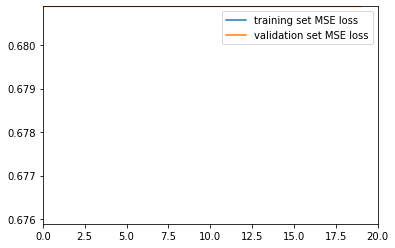

In [11]:
loss_plot(train_loss, "training")
loss_plot(val_loss, "validation")

In [12]:
def test():
    test_iter = iter(test_loader)
    for i in range(8):
        test_imgs, _ = test_iter.next()
        test_imgs, test_noisy_imgs = apply_noise(test_imgs)

        output = autoencoder(test_noisy_imgs)
        test_noisy_imgs = test_noisy_imgs.view(4, 1, 28, 28)
        test_noisy_imgs = test_noisy_imgs.detach().numpy()
        output = output.view(4, 1, 28, 28)
        output = output.detach().numpy()

        fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10,4))
        for test_noisy_imgs, row in zip([test_noisy_imgs, output], axes):
            for img, ax in zip(test_noisy_imgs, row):
                ax.imshow(np.squeeze(img), cmap='gray')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

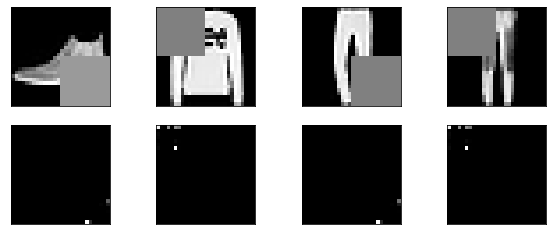

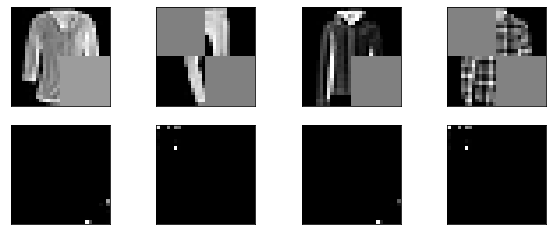

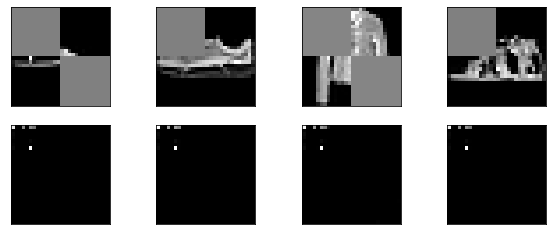

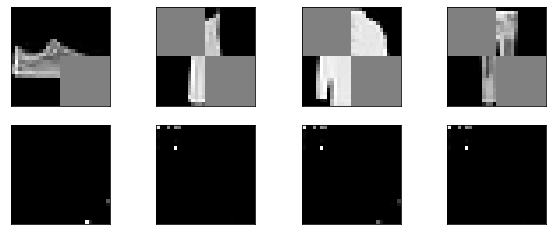

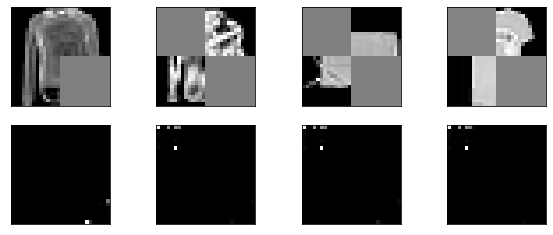

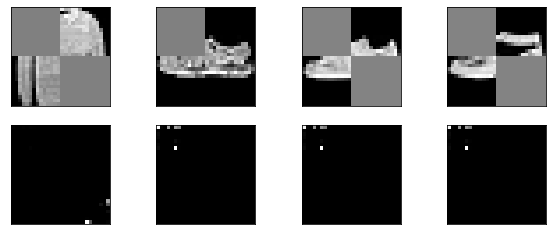

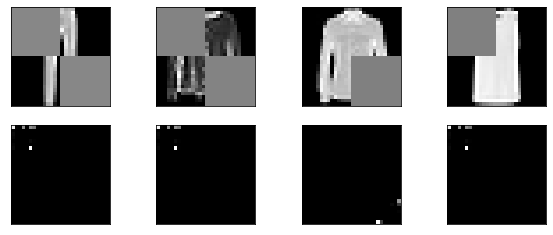

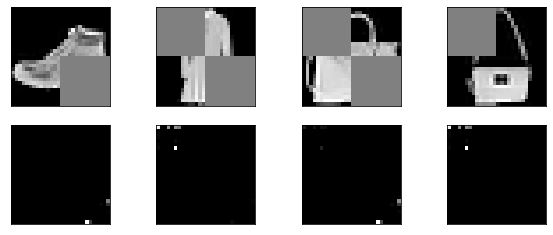

In [13]:
test()